In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def crawl_article(url):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()
            
            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]
                
        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime,
            'push_ipdate': push_ipdatetime.split(' ')[0].strip()
        })
        
        #comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        #'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count,
        'messages': messages
    }

    return data, messages

In [3]:
def crawl_comment(amount=50):

    all_data = []
    comments = []
    nextPage = PTT_URL

    while len(all_data) <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                #如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(all_data) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(all_data)}')
                    return all_data, comments
                
                # 呼叫上面寫好的 function 來對文章進行爬蟲
                parse_data, parse_comment = crawl_article(article_URL)
                #parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))

                # 將爬完的資料儲存
                all_data.append(parse_data)
                comments.extend(parse_comment)

    return all_data, comments

In [4]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [5]:
def getStopWord():
    # 讀取檔案取得stopwords，讓jieba分析更有價值
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [6]:
def jiebaWord(content, topk=20):
    #斷詞並且統計每個詞彙出現的頻率
    
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    
def jiebaCount(data, columnName, topK = 20):
    #透過此function過濾資料，使用jiebaWord斷詞
    all_content = ''
    
    for d in data:
        all_content += d[columnName]
    
    content_pd, content_tags = jiebaWord(all_content, topK)

    return content_pd, content_tags

In [7]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    #font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [8]:
def CollectIPInfo(inputData, author_ip, author_id, times):
    #觀察每個IP有多少人使用來發文/推文
    
    ipList = list()
    
    for ip in inputData[author_ip]:
        if not ip in ipList:
            ipList.append(ip)
    
    tempPd = pd.DataFrame(ipList)
    tempPd = tempPd.rename({0:author_ip}, axis='columns')
    
    user_id = []       # 裝每個發/推文者的id
    authorCount = []      # 裝每個ip的推/發文數或推/發文人數
    
    
    for ip in ipList:
        tempData = inputData[inputData[author_ip] == ip]
        tempList = list()
        
        #計算同一個ip，總共有幾個人使用，同id只算一次
        for identification in tempData[author_id]:
            if identification not in tempList:
                tempList.append(identification)
            
        user_id.append(';'.join(tempList))
        authorCount.append(len(tempList))
    
    tempPd[author_id] = user_id
    tempPd[times] = authorCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd

In [9]:
def CollectUserInfo(inputData, author, content, times):
    #觀察每個id發了多少文章/推了多少文章
    
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id
    articleCount = []      # 裝每個id的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        # 取得同author的所有文章內容，並且計算總共發了幾篇文章
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [10]:
import time

start = time.time()
data, comments = crawl_comment(500)
save_data(data)
print('time difference:', time.time() - start)

Parse Re: [討論] 居住正義要怎麼做才能成功？ - https://www.ptt.cc/bbs/HatePolitics/M.1600829274.A.C8D.html
Parse Re: [討論] 為何瘋狂酸蔡英文好運？ - https://www.ptt.cc/bbs/HatePolitics/M.1600829839.A.091.html
Reach the last article of this page
Parse [黑特] 4%黨召委要投給KMT - https://www.ptt.cc/bbs/HatePolitics/M.1600826178.A.7E5.html
Parse [新聞] 為什麼日本擔憂北海道變成中國的？中國爆買了多少？目的何在 - https://www.ptt.cc/bbs/HatePolitics/M.1600826569.A.D25.html
Parse [黑特] 檢舉魔人? 亂開罰? 蔡英文政府官逼民反! - https://www.ptt.cc/bbs/HatePolitics/M.1600826829.A.DE7.html
Parse [討論] 居住正義要怎麼做才能成功？ - https://www.ptt.cc/bbs/HatePolitics/M.1600826838.A.11C.html
Parse Re: [討論] 為何瘋狂酸蔡英文好運？ - https://www.ptt.cc/bbs/HatePolitics/M.1600827017.A.C58.html
Parse [新聞] 馬英九：美航母艦齡老化　台海若發生戰 - https://www.ptt.cc/bbs/HatePolitics/M.1600827256.A.DDE.html
Parse Re: [討論] 蔡同學論文現在是在改錯字大賽嗎 - https://www.ptt.cc/bbs/HatePolitics/M.1600827291.A.A8A.html
Parse Re: [黑特] 4%黨召委要投給KMT - https://www.ptt.cc/bbs/HatePolitics/M.1600827578.A.769.html
Parse Re: [黑特] 歷任的總統有像蔡英文這樣嗎? - https://www.ptt.cc/b

Parse Re: [新聞] 國軍訂88杯突然棄單　蔡英文親赴飲料店買 - https://www.ptt.cc/bbs/HatePolitics/M.1600786390.A.AFF.html
Parse [討論] 是不是該舉辦幫阿北想公關徵文比賽？？？ - https://www.ptt.cc/bbs/HatePolitics/M.1600786627.A.101.html
Parse [討論] 2022後柯Ｐ如果被立院五虎逼宮怎辦 - https://www.ptt.cc/bbs/HatePolitics/M.1600786780.A.857.html
Parse [討論] 與灣灣之書 - https://www.ptt.cc/bbs/HatePolitics/M.1600786997.A.09B.html
Parse [新聞] 辯稱「俠女」留言打成「妓女」 侮辱男卸責加重判罰 - https://www.ptt.cc/bbs/HatePolitics/M.1600787046.A.EAB.html
Parse [討論] 愛國飲料真的爽 - https://www.ptt.cc/bbs/HatePolitics/M.1600787204.A.862.html
Parse Re: [討論] 阿北到底什麼時候黑掉的？ - https://www.ptt.cc/bbs/HatePolitics/M.1600787786.A.BC3.html
Parse [新聞]致詞麥克風遭消音 馬英九尷尬：不是民進黨 - https://www.ptt.cc/bbs/HatePolitics/M.1600787836.A.81F.html
Parse Re: [討論] FB不能「防爆」，是不是很不方便？ - https://www.ptt.cc/bbs/HatePolitics/M.1600788138.A.EA6.html
Parse Re: [討論] 蔡英文不過是去澎湖付個錢 崩成這樣？ - https://www.ptt.cc/bbs/HatePolitics/M.1600788349.A.1E3.html
Parse Re: [討論] 怎麼不監督政府了？ - https://www.ptt.cc/bbs/HatePolitics/M.1600788391.A.129.htm

Parse [討論] 2022北台灣國民黨很穩 - https://www.ptt.cc/bbs/HatePolitics/M.1600768613.A.E27.html
Parse [討論] 阿北到底什麼時候黑掉的？ - https://www.ptt.cc/bbs/HatePolitics/M.1600768759.A.8E4.html
Parse Re: [討論] 這次事件就能看出兩邊差距了.. - https://www.ptt.cc/bbs/HatePolitics/M.1600768841.A.360.html
Parse [新聞] 簽美豬公投與柯文哲不同調？蔡壁如：民眾 - https://www.ptt.cc/bbs/HatePolitics/M.1600769014.A.2D9.html
Parse Re: [討論] 阿北到底什麼時候黑掉的？ - https://www.ptt.cc/bbs/HatePolitics/M.1600769342.A.C11.html
Parse Re: [討論] 阿北到底什麼時候黑掉的？ - https://www.ptt.cc/bbs/HatePolitics/M.1600769460.A.8E6.html
Parse [新聞] 紐約警局中共臥底：內鬼滲透？為中國監 - https://www.ptt.cc/bbs/HatePolitics/M.1600769470.A.47D.html
Parse [黑特] 質疑蔡英文買飲料的到底是在幹嘛？ - https://www.ptt.cc/bbs/HatePolitics/M.1600769479.A.592.html
Parse [討論] 小聖蚊在悲憤幾點的? - https://www.ptt.cc/bbs/HatePolitics/M.1600769524.A.F85.html
Parse [黑特] 台北的天空，不能被韓蠢給汙染了！ - https://www.ptt.cc/bbs/HatePolitics/M.1600769613.A.AD1.html
Parse [黑特] 新加坡好像蠻愛販賣機的? - https://www.ptt.cc/bbs/HatePolitics/M.1600769640.A.167.html
Parse [新聞] 糗爆！高市交通局昨

Parse Re: [黑特] 對北市藍選民而言 那個韓已經沒用了 - https://www.ptt.cc/bbs/HatePolitics/M.1600757018.A.AE1.html
Parse Re: [討論] 防爆部隊動態觀察 - https://www.ptt.cc/bbs/HatePolitics/M.1600757056.A.1AB.html
Parse Re: [討論] 川普推動於大選前進行最高法院大法官投票 - https://www.ptt.cc/bbs/HatePolitics/M.1600757128.A.DF2.html
Parse Re: [黑特] 韓國魚選北市長最先要注意的一點 - https://www.ptt.cc/bbs/HatePolitics/M.1600757433.A.E5D.html
Parse [討論] 為何總統府可以關注到那家店被國軍棄單 - https://www.ptt.cc/bbs/HatePolitics/M.1600757440.A.FCD.html
Parse [討論] 好文分享-瘦肉精相關 - https://www.ptt.cc/bbs/HatePolitics/M.1600757656.A.168.html
Parse Re: [討論] TVBS 北市長受訪民眾政黨傾向支持度(9/18) - https://www.ptt.cc/bbs/HatePolitics/M.1600757723.A.1B3.html
Parse Re: [黑特] 每次看阿苗打臉柯文折這垃圾 - https://www.ptt.cc/bbs/HatePolitics/M.1600751017.A.93D.html
Parse [轉錄] Jessie 澎湖官兵戰務棄單茶飲 小英今買單 - https://www.ptt.cc/bbs/HatePolitics/M.1600751027.A.F11.html
Parse Re: [黑特] 協尋台北市勞動局跟柯韓糞 - https://www.ptt.cc/bbs/HatePolitics/M.1600751033.A.464.html
Parse [黑特] 對北市藍選民而言 那個韓已經沒用了 - https://www.ptt.cc/bbs/HatePolitics/M.160

Parse [討論] 柯黑笑死了 - https://www.ptt.cc/bbs/HatePolitics/M.1600737683.A.AF7.html
Parse Re: [討論] 2020 TVBS 台北市受訪民眾政黨傾向百分比 - https://www.ptt.cc/bbs/HatePolitics/M.1600737692.A.4EE.html
Parse Re: [轉錄] 莫羽靜   陳志明公威啊 - https://www.ptt.cc/bbs/HatePolitics/M.1600738683.A.885.html
Parse [新聞] 立院院會同意 北院續押蘇震清等3立委 - https://www.ptt.cc/bbs/HatePolitics/M.1600739065.A.2B1.html
Parse [討論] 台灣價值 是不是 好棒棒？ - https://www.ptt.cc/bbs/HatePolitics/M.1600739146.A.B28.html
Parse Re: [討論] 受情勢影響造成全台飛官頻繁起飛 一旦... - https://www.ptt.cc/bbs/HatePolitics/M.1600739750.A.6C6.html
Parse Re: [討論] TVBS 北市長受訪民眾政黨傾向支持度(9/18) - https://www.ptt.cc/bbs/HatePolitics/M.1600739895.A.ED9.html
Parse [討論] 彰化普篩沒後續了嗎 就這樣放任亂搞 - https://www.ptt.cc/bbs/HatePolitics/M.1600739959.A.9B2.html
Parse Re: [討論] 川普推動於大選前進行最高法院大法官投票 - https://www.ptt.cc/bbs/HatePolitics/M.1600740176.A.C66.html
Parse Re: [新聞] 營造業大缺工 內政部次長提開放移工建宅 - https://www.ptt.cc/bbs/HatePolitics/M.1600740247.A.C02.html
Parse Re: [新聞] 營造業大缺工 內政部次長提開放移工建宅 - https://www.ptt.cc/bbs/Hat

Parse [討論] 高雄市議會 質詢市長時間維持十分鐘 - https://www.ptt.cc/bbs/HatePolitics/M.1600697192.A.AA2.html
Parse [討論] 勞保破產 超爽see - https://www.ptt.cc/bbs/HatePolitics/M.1600697268.A.9C6.html
Parse [黑特] 感謝中國把香港帶走 - https://www.ptt.cc/bbs/HatePolitics/M.1600697380.A.1F3.html
Parse [討論] 蔣萬安可以布局新竹市長選舉了 - https://www.ptt.cc/bbs/HatePolitics/M.1600697451.A.0EC.html
Parse Re: [新聞] 立委收賄案》徐永明期約沒收錢內幕 原來 - https://www.ptt.cc/bbs/HatePolitics/M.1600697526.A.B28.html
Parse [討論] 為何台海像要打仗了但新台幣一直漲？ - https://www.ptt.cc/bbs/HatePolitics/M.1600697870.A.162.html
Parse [討論] 韓市長當選後，會怎麼復興台北東區？ - https://www.ptt.cc/bbs/HatePolitics/M.1600697950.A.DC8.html
Parse [討論] 為了台北市民好 應由韓國瑜代表國民黨選 - https://www.ptt.cc/bbs/HatePolitics/M.1600698154.A.88D.html
Parse [討論] 森喜朗的談話有可能被故意漏譯 - https://www.ptt.cc/bbs/HatePolitics/M.1600698214.A.24B.html
Parse [新聞] 中國太空探索能力遭挫！《路透》獨家： - https://www.ptt.cc/bbs/HatePolitics/M.1600698372.A.315.html
Parse Re: [討論] 陳水扁是不是生錯年代? - https://www.ptt.cc/bbs/HatePolitics/M.1600698552.A.7B5.html
Parse Re: [討論

In [11]:
content_pd, content_tags = jiebaCount(data, 'article_content', 40) #看看發文中，最常出現的詞彙
message_pd, message_tags = jiebaCount(comments, 'push_content', 40) #看看推文中，最常出現的詞彙

Building prefix dict from C:\Users\10904085\Desktop\cupoy\web\Final(PTT)\dict.txt.big ...
Dumping model to file cache C:\Users\10904085\AppData\Local\Temp\jieba.udfa9e734b7eb9a15dde63142dd63170e.cache
Loading model cost 1.074 seconds.
Prefix dict has been built successfully.
Building prefix dict from C:\Users\10904085\Desktop\cupoy\web\Final(PTT)\dict.txt.big ...
Loading model from cache C:\Users\10904085\AppData\Local\Temp\jieba.udfa9e734b7eb9a15dde63142dd63170e.cache
Loading model cost 1.094 seconds.
Prefix dict has been built successfully.


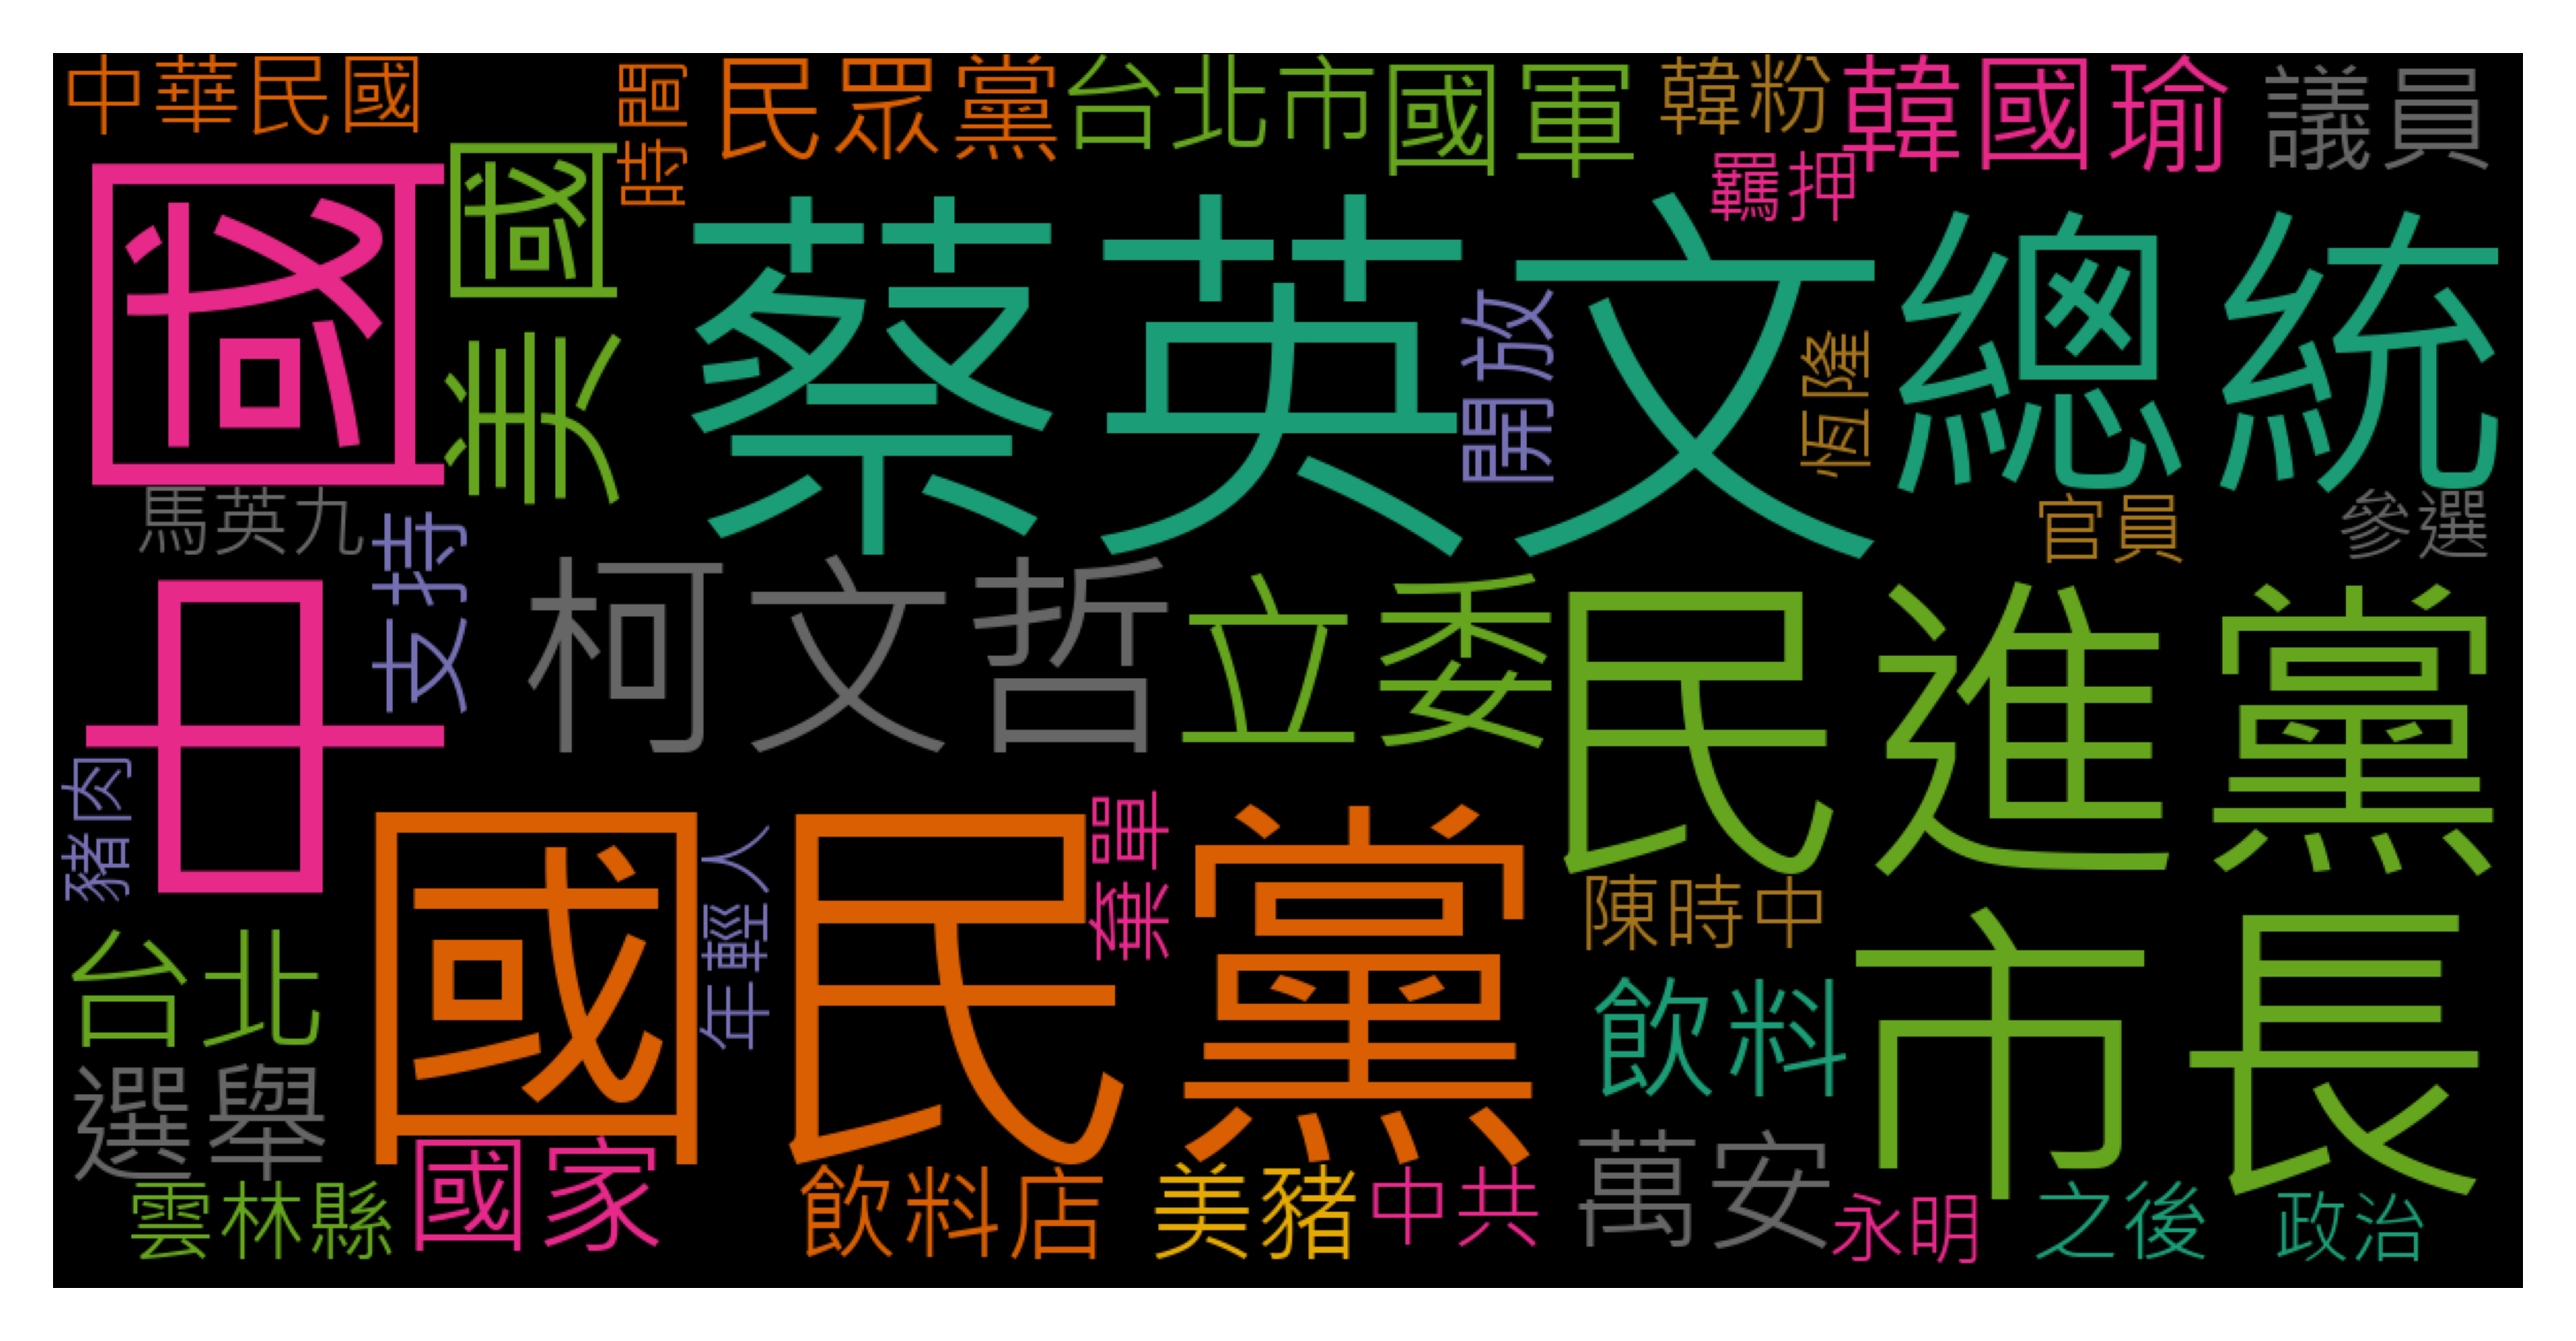

In [12]:
wordcloudPTT(content_tags) #發文的文字雲

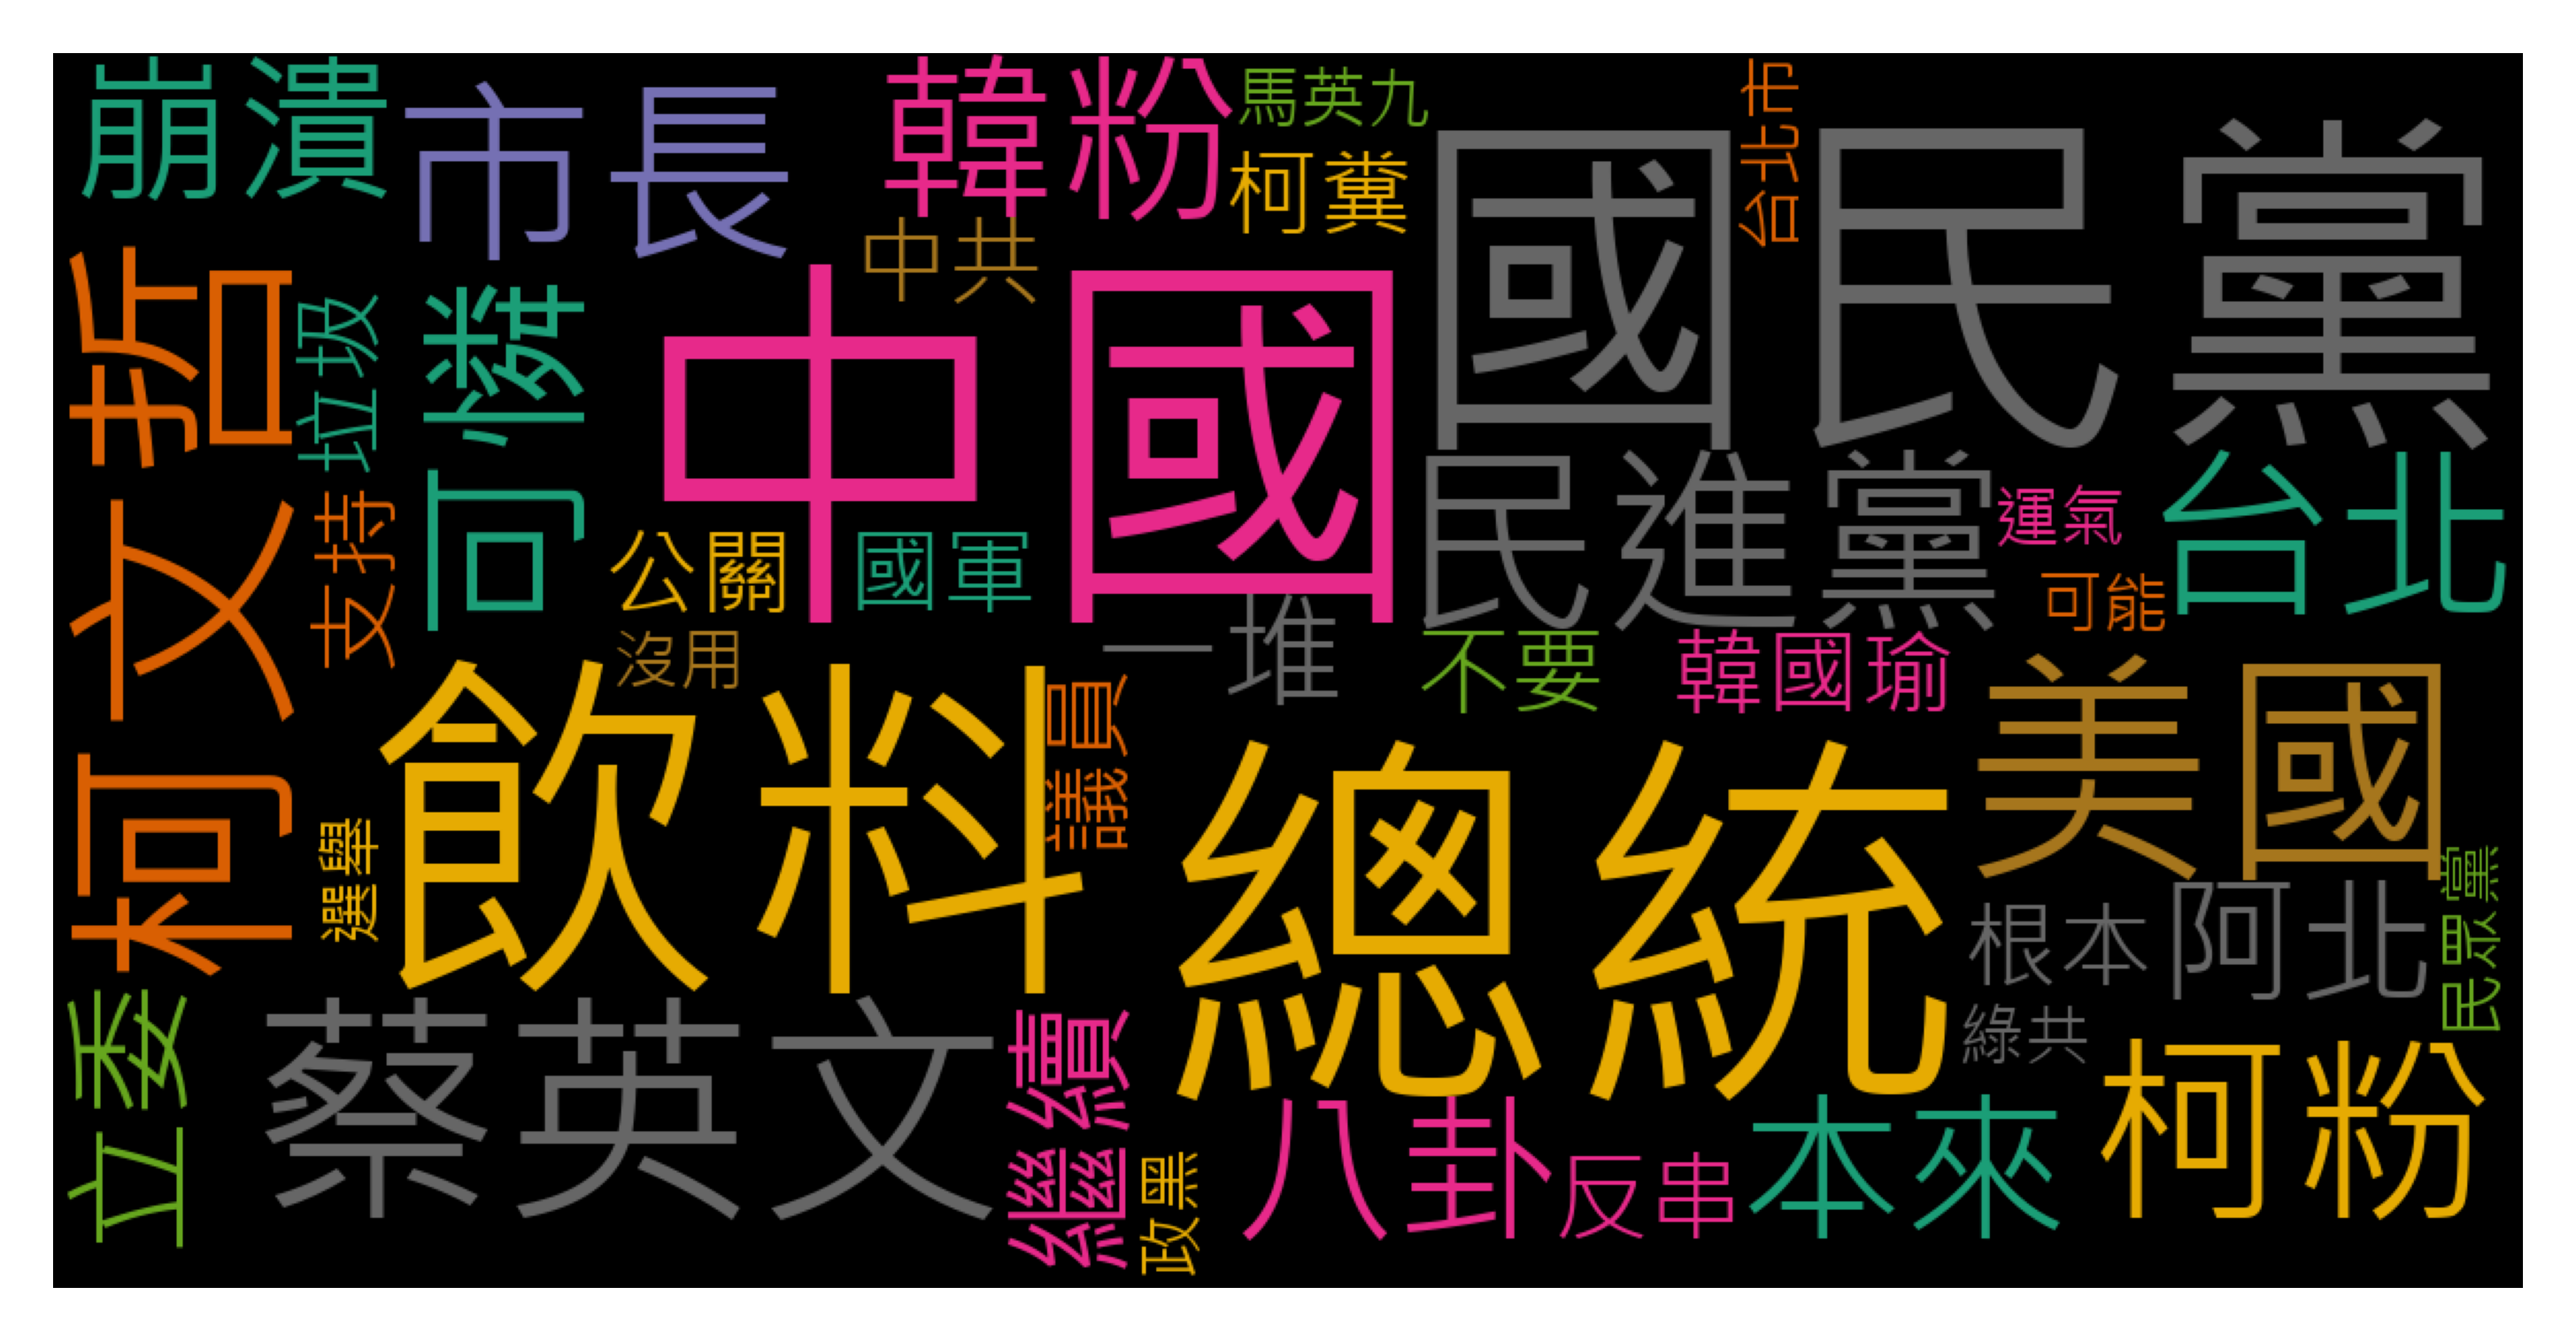

In [13]:
wordcloudPTT(message_tags) #推文的文字雲

In [14]:
content_pd.sort_values(by=['Times'], ascending = False) #發文最常出現的詞彙以及其頻率

,KeyWords,Times
0,中國,407
1,國民黨,370
2,蔡英文,308
3,民進黨,287
4,市長,277
5,總統,269
10,台北,253
6,柯文哲,243
19,支持,231
8,美國,218


In [15]:
message_pd.sort_values(by=['Times'], ascending = False) #推文最常出現的詞彙以及其頻率

,KeyWords,Times
0,時力,501
1,民進黨,360
2,基進,349
3,柯粉,309
4,黃捷,297
5,韓粉,267
6,中國,260
20,不要,257
23,支持,234
7,民眾黨,221


In [15]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [23]:
most_article_user = CollectUserInfo(pddata, 'article_author_id', 'article_content', 'article_times')
most_push_user = CollectUserInfo(pdmessage, 'push_userid', 'push_content', 'push_times')

In [24]:
most_ip_author = CollectIPInfo(pddata, 'ip', 'article_author_id', 'author_count')
most_ip_push = CollectIPInfo(pdmessage, 'push_ipdatetime', 'push_userid', 'push_userid_count')
most_pushCount_date = CollectIPInfo(pdmessage, 'push_ipdate', 'push_userid', 'push_userid_count')

In [25]:
most_article_user

,index,article_author_id,article_content,article_times
0,51,nicholas0406,奇怪了 很多柯粉一直認為說\n\n民進黨怕柯文哲選2024 所以派1450 網軍出來打壓柯文...,9
1,48,FoRTuNaTeR,https://upload.cc/i1/2020/09/23/Ah1MXe.jpg 此舉等...,8
2,27,Zionward,館長溫柔提醒\n 目前已有專業保鏢守護\n 接近館長20公尺內，切勿有攻擊意圖及動作\n ...,7
3,64,Gavatzky,首先\n\n各位對戰爭要有兩種認知\n\n第一個\n\n戰爭中絕對沒有哪一個國家是穩贏的\n...,7
4,50,Rrrxddd,餓死抬頭\n\n為什麼台北發生火災\n台中發生氣爆 這樣的事情\n卻引起不了共鳴？\n\n一...,7
...,...,...,...,...
251,136,lemon0970,于北辰今天說 國民黨沒有誘因讓年輕人加入\n\n認為說台灣就是搞台獨 而蔡英文很厲害\n...,1
252,137,Acalanatha,3年前，只要黑阿北的，個個死無葬身之地，\n\n最有名的就那個問肚臍英文怎麼拼的誰誰誰啦\n...,1
253,141,haehae311444,話說 某人請的公關公司這波操作 我真的不懂\n讓我覺得根本是在騙錢的吧\n說做秀 哪個政治人...,1
254,142,Yolosnow,https://i.imgur.com/n1f3TZQ.jpg 蔡英文買個飲料就在那邊酸\n...,1


In [26]:
most_push_user

,index,push_userid,push_content,push_times
0,346,FoRTuNaTeR,還好，妳沒看過這照片;https://upload.cc/i1/2020/08/08/Oxn...,957
1,0,WTF55665566,同意這一點;但房屋供給可以同步處理吧？不然推公宅的用意是？;不意外垃圾 小紅;整天嗆任小綠 ...,334
2,436,foolfighter,賺到不知人;阿北怎麼沒有領獎？？？;八卦柯糞意外嗎？ 根本就yahoo化;柯狗死豬不怕滾水燙...,267
3,21,Moratti,要蔣萬安帶 他們的議員候選人跑行程吧;他的好運 被2018的三千票給毀了;對啊 如果捧的人是...,266
4,169,EggAcme,所以柯韓粉有證據是店家演的?有證據就拿出來阿?還是現在;柯韓粉指控都不用有證據，憑我感覺就可...,233
...,...,...,...,...
1527,937,autokey,誰看的出來是公家掛的~????????,1
1528,943,fxntdsxdr,這篇還真多邏輯大師,1
1529,946,leader223,你得到他了,1
1530,948,Wcw5504,這是印度故意報來噁心中國的吧,1


In [27]:
most_ip_author

,index,ip,article_author_id,author_count
0,0,223.140.254.110,hagousla,1
1,209,59.120.195.222,tigerzz3,1
2,216,111.240.123.4,RX00,1
3,215,114.27.114.48,pqbd22,1
4,214,101.12.20.105,Saint0822,1
...,...,...,...,...
312,105,1.160.82.71,XindeX,1
313,104,101.14.193.73,a520,1
314,103,49.214.180.77,andycat5566,1
315,102,118.150.253.173,goetze,1


In [28]:
most_ip_push

,index,push_ipdatetime,push_userid,push_userid_count
0,1127,09/22 13:23,Moratti;DarthCod;obey1110;Atkins13;boogieman;d...,21
1,1111,09/22 13:20,windom;WTF55665566;takuminauki;Atkins13;Moratt...,21
2,1300,09/22 10:58,gunng;ianbh;castalchen;tigerzz3;FoRTuNaTeR;Cav...,19
3,1376,09/22 10:28,lostman;Tiara5566;dakkk;yun0112;pbkfss;foolfig...,19
4,1110,09/22 13:19,windom;takuminauki;chenyei;zeuswell;boogieman;...,18
...,...,...,...,...
2013,1616,09/22 04:25,ota978,1
2014,1615,09/22 07:01,DameKyon,1
2015,1614,09/22 05:15,FoRTuNaTeR,1
2016,1613,09/22 04:10,FoRTuNaTeR,1


In [29]:
most_pushCount_date

,index,push_ipdate,push_userid,push_userid_count
0,2,09/22,platinum500a;pinacolada;Atkins13;virginia779;C...,1268
1,0,09/23,WTF55665566;latin0126;kairi5217;a2550099;uieas...,599
2,4,09/21,bruce2248;genheit;Moratti;MrJohn;wx190;elainak...,251
3,1,07/22,ubcs,1
4,3,192.192.154.43,luluhihi,1
